In [11]:
import json
import pandas as pd
from typing import DefaultDict, List
import numpy as np
import seaborn as sns
import logging

ERROR:root:Expecting ',' delimiter: line 1 column 17256 (char 17255)


<AxesSubplot: xlabel='operation', ylabel='success_prob'>

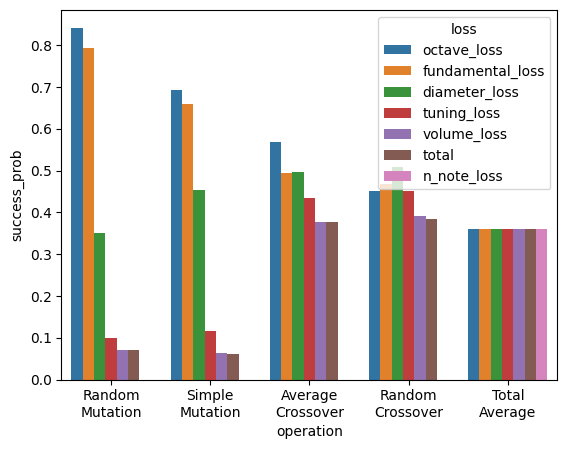

In [44]:
class Node:

    def __init__(self, genome_id, losses, generation):
        self.genome_id = genome_id
        self.losses = losses
        self.generation = generation
        self.children = []
        self.parents = []

    def add_child(self, child_node, edge_name, edge_params):
        con = Edge(edge_name, edge_params, self, child_node)
        self.children.append(con)

    def add_parent(self, parent_node, edge_name, edge_params):
        con = Edge(edge_name, edge_params, parent_node, self)
        self.parents.append(con)

class Edge:

    def __init__(self, name, params, parent, child):
        self.name = name
        self.params = params
        self.parent = parent
        self.child = child

class Nodes:

    def __init__(self):
        self.nodes = {}

    def add_node(self, node):
        self.nodes[node.genome_id] = node

    def has_node_id(self, node_id):
        return node_id in self.nodes.keys()

    def get_node(self, node_id):
        return self.nodes[node_id]
    
    def get_generation(self, i_generation):
        return list(filter(lambda x:x.generation==i_generation, self.nodes.values()))

    def get_all_edges(self):
        for node in self.nodes.values():
            for edge in node.children:
                yield edge

    def connect(self, nodeid_parent, nodeid_child, edge_name, edge_params):
        parent = self.get_node(nodeid_parent)
        child = self.get_node(nodeid_child)
        parent.add_child(child, edge_name, edge_params)
        child.add_parent(parent, edge_name, edge_params)

def build_graph(infile):
    generation_counter = 0
    nodes = Nodes()
    num_errors = 0
    for line in open(infile):
        try:
            data = json.loads(line)
        except Exception as e:
            num_errors += 1
            if num_errors >= 3:
                break
            logging.error(e)
            continue
        for i in range(len(data["genome_ids"])):

            losses = {key: data["losses"][key][i] for key in data["losses"].keys()}
            node = Node(
                data["genome_ids"][i], 
                losses,
                generation_counter
            )
            nodes.add_node(node)
        generation_counter += 1

        mo = data["mutations_operations"]
        if len(mo)>0:
            for i in range(len(mo["operation"])):
                father_id = mo["father_id"][i]
                child_id = mo["child_id"][i]

                if nodes.has_node_id(child_id) and nodes.has_node_id(father_id):
                    nodes.connect(
                        father_id,
                        child_id,
                        mo["operation"][i],
                        {}
                    )

        co = data["crossover_operations"]
        if len(co)>0:
            for i in range(len(co["operation"])):
                parent1 = co["parent1_genome"][i]
                parent2 = co["parent2_genome"][i]
                child_id = co["child_id"][i]
                if nodes.has_node_id(child_id) and nodes.has_node_id(parent1) and nodes.has_node_id(parent2):
                        nodes.connect(
                            parent1,
                            child_id,
                            co["operation"][i],
                            {}
                        )
                        nodes.connect(
                            parent2,
                            child_id,
                            co["operation"][i],
                            {}
                        )
    return nodes

def get_deltas(infile):
    nodes = build_graph(infile)
    deltas = []
    for edge in nodes.get_all_edges():
        for key in edge.parent.losses.keys():
            loss_delta = edge.parent.losses[key] - edge.child.losses[key]
            deltas.append([edge.name, key, np.max((0, loss_delta))])
    deltas = pd.DataFrame(deltas, columns=["operation", "loss", "delta"])
    return deltas

def get_success_probs(deltas):
    success_probs = []
    for loss in deltas.loss.unique():
        for operation in deltas.operation.unique():
            a = len(deltas.query("operation==@operation and loss==@loss and delta>0"))    
            b = len(deltas.query("operation==@operation and loss==@loss"))
            operation_str = operation
            operation_str = operation_str.replace("Mutation", "\nMutation")
            operation_str = operation_str.replace("Crossover", "\nCrossover")
            success_probs.append([operation_str, loss, a/b])

        a = len(deltas.query("delta>0"))    
        b = len(deltas)
        success_probs.append(["Total\nAverage", loss, a/b])

    success_probs = pd.DataFrame(success_probs, columns=["operation", "loss", "success_prob"])
    success_probs = success_probs.sort_values("success_prob", ascending=False)
    return success_probs

infile = '../../../evolutions/2024-04-06T11-20-41_evolve_arusha/evolution_operations.jsonl'
deltas = get_deltas(infile)
success_probs = get_success_probs(deltas)
sns.barplot(data=success_probs, x="operation", y="success_prob", hue="loss")


<AxesSubplot: xlabel='operation', ylabel='success_prob'>

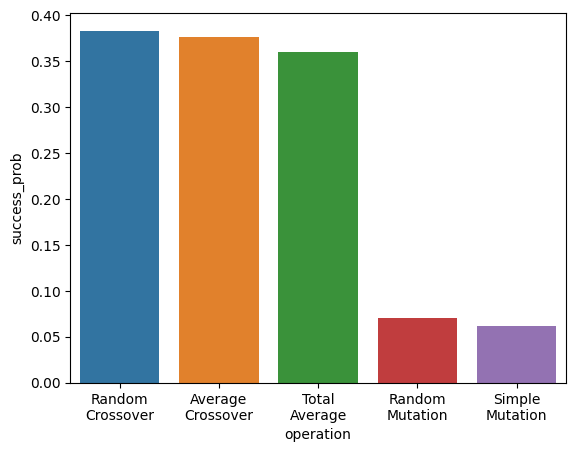

In [45]:
sns.barplot(data=success_probs.query("loss=='total'"), x="operation", y="success_prob")

In [48]:
deltas.query("loss=='total'").operation.value_counts()

RandomCrossover     3760
AverageCrossover    3698
RandomMutation      1825
SimpleMutation      1765
Name: operation, dtype: int64

In [38]:
deltas

,operation,delta
0,RandomMutation,0.000000
1,AverageCrossover,0.000000
2,AverageCrossover,0.000000
3,RandomCrossover,0.000000
4,AverageCrossover,0.000000
...,...,...
11043,RandomCrossover,0.312390
11044,RandomMutation,0.000000
11045,RandomCrossover,0.000000
11046,AverageCrossover,5.870071
